In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader,random_split
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
np.random.seed(0)
torch.manual_seed(0)

In [19]:
data = pd.read_csv('pbmc_data.csv')
df = data.iloc[:,1:-2]
X = torch.tensor(df.values).float()
Y = data.iloc[:,-2].values
Y = torch.tensor(Y).long()

In [20]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [21]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512,hidden_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.ReLU(True),
            nn.Linear(512,1024),
            nn.ReLU(True),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
def train(model, train_loader,test_loader, criterion, optimizer, num_epochs,isAE = False):
    training_loss = []
    test_loss = []
    training_acc = []
    test_acc = [] 
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        train_acc = 0
        model.train()
        for data in train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (output.argmax(1) == y.argmax(1)).sum().item()
        train_loss /= len(train_loader)
        train_acc /= len(train_loader.dataset)
        training_loss.append(train_loss)
        training_acc.append(train_acc) 
        
        test_acc_value = 0.0
        test_loss_value = 0.0
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                output = model(x)
                loss = criterion(output, y)
                test_loss_value += loss.item()
                test_acc_value += (output.argmax(1) == y.argmax(1)).sum().item()
            test_loss.append(test_loss_value / len(test_loader))
            test_acc.append(test_acc_value / len(test_loader.dataset))
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f}'
              .format(epoch + 1, num_epochs, train_loss, train_acc, test_loss[-1], test_acc[-1]))
        scheduler.step(test_loss_value)
    plt.plot(training_loss)
    plt.plot(test_loss)
    if not isAE:
        plt.plot(training_acc)
    if not isAE:
        plt.plot(test_acc)
    plt.legend(['Training Loss', 'Test Loss', 'Training Accuracy', 'Test Accuracy'])
    plt.show()  # 显示训练损失图
    return model


torch.Size([2638, 1838])


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Training Loss: 0.8563, Training Accuracy: 0.0004, Test Loss: 0.8276, Test Accuracy: 0.0000
Epoch [2/50], Training Loss: 0.8376, Training Accuracy: 0.0000, Test Loss: 0.8344, Test Accuracy: 0.0000
Epoch [3/50], Training Loss: 0.8342, Training Accuracy: 0.0000, Test Loss: 0.8263, Test Accuracy: 0.0000
Epoch [4/50], Training Loss: 0.8279, Training Accuracy: 0.0004, Test Loss: 0.8264, Test Accuracy: 0.0000
Epoch [5/50], Training Loss: 0.8274, Training Accuracy: 0.0000, Test Loss: 0.8192, Test Accuracy: 0.0000
Epoch [6/50], Training Loss: 0.8272, Training Accuracy: 0.0000, Test Loss: 0.8323, Test Accuracy: 0.0000
Epoch [7/50], Training Loss: 0.8268, Training Accuracy: 0.0000, Test Loss: 0.8226, Test Accuracy: 0.0000
Epoch [8/50], Training Loss: 0.8247, Training Accuracy: 0.0000, Test Loss: 0.8304, Test Accuracy: 0.0000
Epoch [9/50], Training Loss: 0.8242, Training Accuracy: 0.0000, Test Loss: 0.8258, Test Accuracy: 0.0000
Epoch [10/50], Training Loss: 0.8238, Training Accuracy

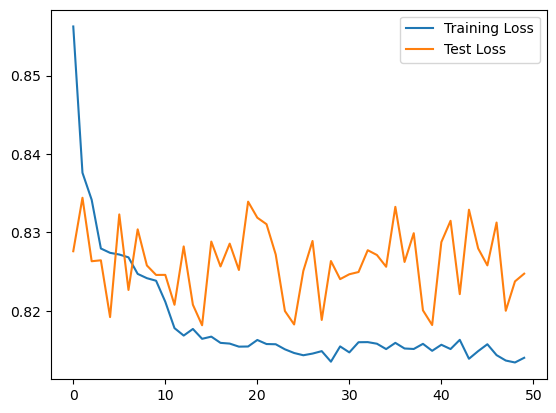

In [24]:
import torch.utils


autoencoder = AutoEncoder(X.shape[1], 2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0005)
dataset = Dataset(X,X)
print(X.shape)
# 确定训练集和测试集的大小
train_size = int(0.9 * len(dataset))  # 80%用于训练
test_size = len(dataset) - train_size  # 剩余20%用于测试

# 随机分割数据集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
autoencoder = train(autoencoder, train_loader,test_loader, criterion, optimizer, 50,isAE=True)

'\nfrom sklearn.decomposition import PCA\nfrom sklearn.manifold import TSNE\nfrom sklearn.preprocessing import StandardScaler\nimport umap\nUMAP = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)\n\nstandardized_df = StandardScaler().fit_transform(XX)\numap_result = UMAP.fit_transform(standardized_df)\nplt.figure(figsize=(7,7))\nplt.title("UMAP plot")\nplt.xlabel("UMAP 1")\nplt.ylabel("UMAP 2")\ncmap = plt.cm.colors.ListedColormap(plt.cm.tab20.colors)\nplt.scatter(umap_result[:,0], umap_result[:,1],c=cmap(Y),s=1)\ndic = {}\n#for i in len(data[\'cell_type\'].iloc[:]):\n#    dic[data[\'cell_type\'][i]] = data[\'cell_type_str\'][i]   \ncell_type_mapping = dict(zip(data[\'cell_type\'], data[\'cell_type_string\']))\n\nlegend_elements = [plt.Line2D([0], [0], marker=\'o\', color=\'w\', label=cell_type_mapping[i],\n                              markerfacecolor=cmap(i), markersize=10) \n                   for i in range(7)]\nplt.legend(handles=legend_elements, title=\'Cell Types\', loc=\

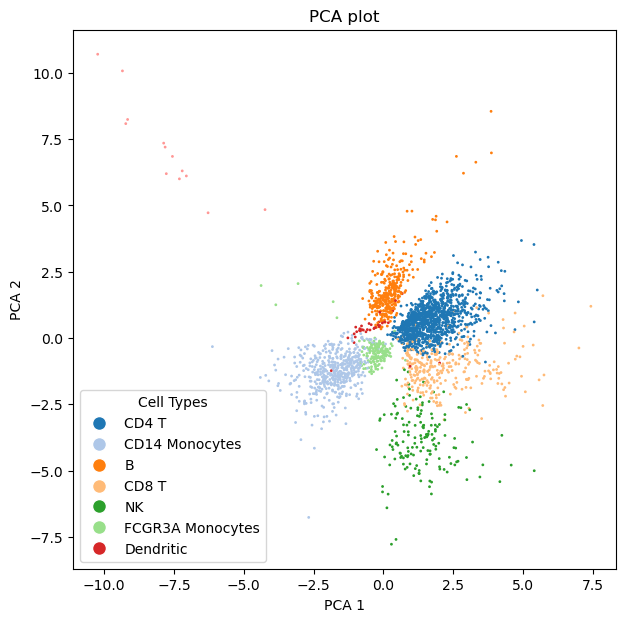

In [25]:
autoencoder.eval()
XX = autoencoder.cpu().encoder(X).detach().numpy()

plt.figure(figsize=(7,7))
plt.title("PCA plot")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
cmap = plt.cm.colors.ListedColormap(plt.cm.tab20.colors)
plt.scatter(XX[:,0], XX[:,1],c=cmap(Y),s=1)
dic = {}
cell_type_mapping = dict(zip(data['cell_type'], data['cell_type_string']))

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=cell_type_mapping[i],
                              markerfacecolor=cmap(i), markersize=10) 
                   for i in range(7)]
plt.legend(handles=legend_elements, title='Cell Types', loc='best')
'''
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
UMAP = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)

standardized_df = StandardScaler().fit_transform(XX)
umap_result = UMAP.fit_transform(standardized_df)
plt.figure(figsize=(7,7))
plt.title("UMAP plot")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
cmap = plt.cm.colors.ListedColormap(plt.cm.tab20.colors)
plt.scatter(umap_result[:,0], umap_result[:,1],c=cmap(Y),s=1)
dic = {}
#for i in len(data['cell_type'].iloc[:]):
#    dic[data['cell_type'][i]] = data['cell_type_str'][i]   
cell_type_mapping = dict(zip(data['cell_type'], data['cell_type_string']))

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=cell_type_mapping[i],
                              markerfacecolor=cmap(i), markersize=10) 
                   for i in range(7)]
plt.legend(handles=legend_elements, title='Cell Types', loc='best')
'''


In [26]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

torch.Size([2638, 8])


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Training Loss: 1.8084, Training Accuracy: 0.4209, Test Loss: 1.4810, Test Accuracy: 0.7538
Epoch [2/100], Training Loss: 1.1831, Training Accuracy: 0.8602, Test Loss: 1.0209, Test Accuracy: 0.8314
Epoch [3/100], Training Loss: 0.7539, Training Accuracy: 0.8919, Test Loss: 0.7064, Test Accuracy: 0.8580
Epoch [4/100], Training Loss: 0.4962, Training Accuracy: 0.9246, Test Loss: 0.5294, Test Accuracy: 0.8902
Epoch [5/100], Training Loss: 0.3488, Training Accuracy: 0.9474, Test Loss: 0.4296, Test Accuracy: 0.9034
Epoch [6/100], Training Loss: 0.2555, Training Accuracy: 0.9640, Test Loss: 0.3612, Test Accuracy: 0.9167
Epoch [7/100], Training Loss: 0.1925, Training Accuracy: 0.9787, Test Loss: 0.3171, Test Accuracy: 0.9337
Epoch [8/100], Training Loss: 0.1484, Training Accuracy: 0.9863, Test Loss: 0.2804, Test Accuracy: 0.9337
Epoch [9/100], Training Loss: 0.1165, Training Accuracy: 0.9938, Test Loss: 0.2596, Test Accuracy: 0.9356
Epoch [10/100], Training Loss: 0.0928, Trainin

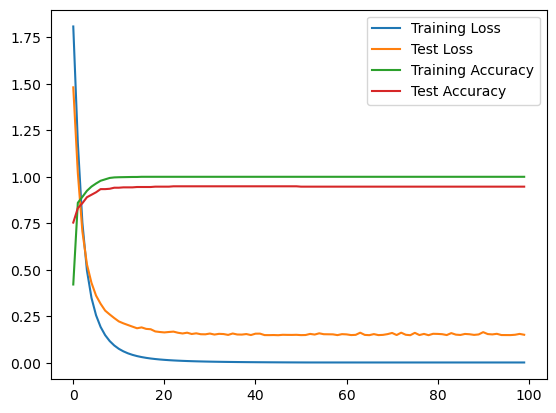

In [34]:
Y = data.iloc[:,-2].values
Y = np.eye(8)[Y]
Y = torch.tensor(Y).float()
print(Y.shape)
classifier = Classifier(X.shape[1], 100,8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
dataset = Dataset(X,Y)
# 确定训练集和测试集的大小
train_size = int(0.8 * len(dataset))  # 80%用于训练
test_size = len(dataset) - train_size  # 剩余20%用于测试

# 随机分割数据集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
classifier = train(classifier, train_loader,test_loader, criterion, optimizer, 100)

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.Dropout1d(),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding, bias=False),
            nn.Dropout1d(),
            nn.BatchNorm1d(out_channels),
        )
        
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        self.pool = nn.MaxPool1d(2)
    def forward(self, x):
        out = self.conv(x)
        out += self.shortcut(x)
        out = F.relu(out)
        out = self.pool(out)
        return out

class ResNet1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ResNet1D, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(64, 128, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(128, 256, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(256, 512, num_blocks=2, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.initial_conv(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.global_avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

torch.Size([2638, 8])


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Training Loss: 1.8095, Training Accuracy: 0.3678, Test Loss: 1.7705, Test Accuracy: 0.4432
Epoch [2/100], Training Loss: 1.6290, Training Accuracy: 0.4171, Test Loss: 1.9376, Test Accuracy: 0.4583
Epoch [3/100], Training Loss: 1.5333, Training Accuracy: 0.4502, Test Loss: 1.8702, Test Accuracy: 0.4621
Epoch [4/100], Training Loss: 1.2227, Training Accuracy: 0.5640, Test Loss: 1.2190, Test Accuracy: 0.6705
Epoch [5/100], Training Loss: 0.8047, Training Accuracy: 0.7213, Test Loss: 0.8429, Test Accuracy: 0.7443
Epoch [6/100], Training Loss: 0.6550, Training Accuracy: 0.7682, Test Loss: 0.6451, Test Accuracy: 0.7917
Epoch [7/100], Training Loss: 0.5613, Training Accuracy: 0.8024, Test Loss: 0.6482, Test Accuracy: 0.8049
Epoch [8/100], Training Loss: 0.4921, Training Accuracy: 0.8265, Test Loss: 0.4759, Test Accuracy: 0.8523
Epoch [9/100], Training Loss: 0.4383, Training Accuracy: 0.8460, Test Loss: 0.7191, Test Accuracy: 0.7955
Epoch [10/100], Training Loss: 0.4224, Trainin

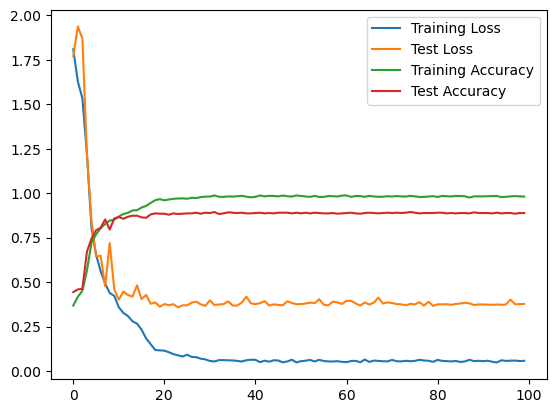

In [29]:
X = torch.tensor(df.values).float()
X = X.unsqueeze(1)
Y = data.iloc[:,-2].values
Y = np.eye(8)[Y]
Y = torch.tensor(Y).float()
print(Y.shape)
classifier = ResNet1D(1, 8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001,weight_decay=1e-4)
dataset = Dataset(X,Y)
# 确定训练集和测试集的大小
train_size = int(0.8 * len(dataset))  # 80%用于训练
test_size = len(dataset) - train_size  # 剩余20%用于测试

# 随机分割数据集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
classifier = train(classifier, train_loader,test_loader, criterion, optimizer, 100)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(LinearResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Linear(in_channels, 2 * in_channels),
            nn.BatchNorm1d(2 * in_channels),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(2 * in_channels, 2 * in_channels),
            nn.BatchNorm1d(2 * in_channels),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(2 * in_channels, out_channels)
        )
        
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Linear(in_channels, out_channels),
            )
    def forward(self, x):
        out = self.conv(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ResNet, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Linear(input_channels, input_channels),
            nn.ReLU()
        )
        self.layer1 = self._make_layer(input_channels,input_channels, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(input_channels,input_channels, num_blocks=2, stride=2)
        self.fc = nn.Linear(input_channels, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(LinearResidualBlock(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))
        for _ in range(1, num_blocks):
            layers.append(LinearResidualBlock(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.initial_conv(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

torch.Size([2638, 8])


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Training Loss: 1.3515, Training Accuracy: 0.7550, Test Loss: 0.2672, Test Accuracy: 0.9205
Epoch [2/100], Training Loss: 0.1851, Training Accuracy: 0.9417, Test Loss: 0.1770, Test Accuracy: 0.9432
Epoch [3/100], Training Loss: 0.0753, Training Accuracy: 0.9782, Test Loss: 0.1590, Test Accuracy: 0.9451
Epoch [4/100], Training Loss: 0.0557, Training Accuracy: 0.9848, Test Loss: 0.2293, Test Accuracy: 0.9432
Epoch [5/100], Training Loss: 0.0369, Training Accuracy: 0.9886, Test Loss: 0.3051, Test Accuracy: 0.9318
Epoch [6/100], Training Loss: 0.0120, Training Accuracy: 0.9948, Test Loss: 0.3514, Test Accuracy: 0.9318
Epoch [7/100], Training Loss: 0.0390, Training Accuracy: 0.9872, Test Loss: 0.2223, Test Accuracy: 0.9451
Epoch [8/100], Training Loss: 0.0289, Training Accuracy: 0.9900, Test Loss: 0.2139, Test Accuracy: 0.9470
Epoch [9/100], Training Loss: 0.0218, Training Accuracy: 0.9891, Test Loss: 0.3445, Test Accuracy: 0.9167
Epoch [10/100], Training Loss: 0.0162, Trainin

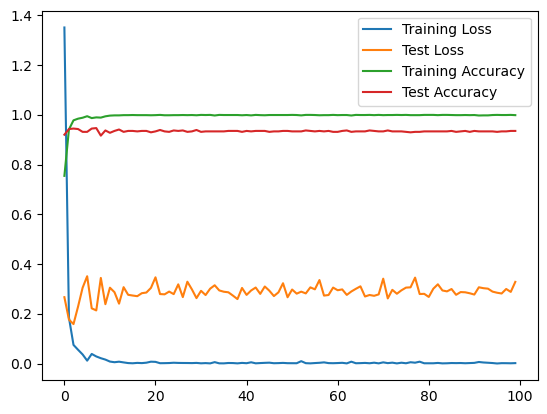

In [31]:
X = torch.tensor(df.values).float()
Y = data.iloc[:,-2].values
Y = np.eye(8)[Y]
Y = torch.tensor(Y).float()
print(Y.shape)
classifier = ResNet(X.shape[1], 8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(classifier.parameters(), lr=0.001)
dataset = Dataset(X,Y)
# 确定训练集和测试集的大小
train_size = int(0.8 * len(dataset))  # 80%用于训练
test_size = len(dataset) - train_size  # 剩余20%用于测试

# 随机分割数据集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
classifier = train(classifier, train_loader,test_loader, criterion, optimizer, 100)

torch.Size([2638, 8])


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Training Loss: 1.6821, Training Accuracy: 0.4237, Test Loss: 1.5897, Test Accuracy: 0.4186
Epoch [2/100], Training Loss: 1.5771, Training Accuracy: 0.4611, Test Loss: 1.4761, Test Accuracy: 0.4280
Epoch [3/100], Training Loss: 1.4768, Training Accuracy: 0.4953, Test Loss: 1.4125, Test Accuracy: 0.4205
Epoch [4/100], Training Loss: 1.3817, Training Accuracy: 0.5303, Test Loss: 1.3169, Test Accuracy: 0.4735
Epoch [5/100], Training Loss: 1.2934, Training Accuracy: 0.5773, Test Loss: 1.2295, Test Accuracy: 0.5000
Epoch [6/100], Training Loss: 1.1996, Training Accuracy: 0.6209, Test Loss: 1.2324, Test Accuracy: 0.5246
Epoch [7/100], Training Loss: 1.1007, Training Accuracy: 0.6616, Test Loss: 1.1468, Test Accuracy: 0.5606
Epoch [8/100], Training Loss: 0.9960, Training Accuracy: 0.7062, Test Loss: 1.0893, Test Accuracy: 0.5814
Epoch [9/100], Training Loss: 0.9069, Training Accuracy: 0.7351, Test Loss: 1.0740, Test Accuracy: 0.5890
Epoch [10/100], Training Loss: 0.8232, Trainin

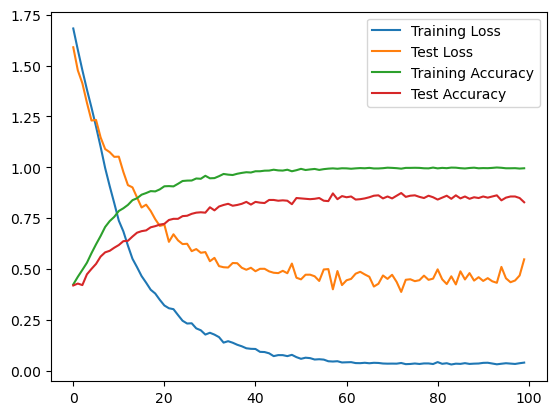

In [37]:
X = torch.tensor(df.values).float()
Y = data.iloc[:,-2].values
Y = np.eye(8)[Y]
Y = torch.tensor(Y).float()
print(Y.shape)
classifier = ResNet(X.shape[1], 8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.001)
dataset = Dataset(X,Y)
# 确定训练集和测试集的大小
train_size = int(0.8 * len(dataset))  # 80%用于训练
test_size = len(dataset) - train_size  # 剩余20%用于测试

# 随机分割数据集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
classifier = train(classifier, train_loader,test_loader, criterion, optimizer, 100)